<h1 align='center'>Gold Proximity in India</h1>
The dataset for this logistic regression exercise is described below:

http://www.stat.ufl.edu/~winner/data/gold_target1.txt

Columns are:

    As level     1-8
    Sb level     10-16
    Lineament Proximity  24  /* 1=Present, 0 if absent  (0.5km)  */
    Gold deposit proximity  32  /* 1=Present, 0=absent  (0.5km)  */

In [1]:
import numpy as np
import pandas as pd
%pylab inline
pylab.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [56]:
url  = 'http://www.stat.ufl.edu/~winner/data/gold_target1.dat'
data_df = pd.read_csv(url, sep='[\s]+', engine='python', header=None)

In [57]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 4 columns):
0    64 non-null float64
1    64 non-null float64
2    64 non-null int64
3    64 non-null int64
dtypes: float64(2), int64(2)
memory usage: 2.1 KB


In [58]:
data_df.columns = ['as_level', 'sb_level', 'l_proximity', 'gold_proximity']

In [59]:
data_df.head()

,as_level,sb_level,l_proximity,gold_proximity
0,6.77,3.08,1,1
1,15.03,6.15,1,1
2,6.43,2.35,1,1
3,0.10,0.30,0,0
4,0.10,0.30,0,0


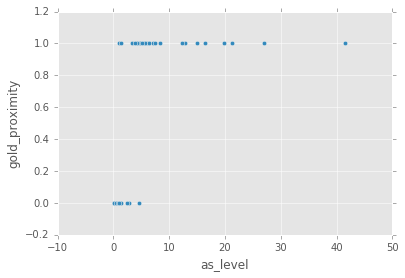

In [11]:
data_df.plot(kind='scatter', x='as_level', y = 'gold_proximity')

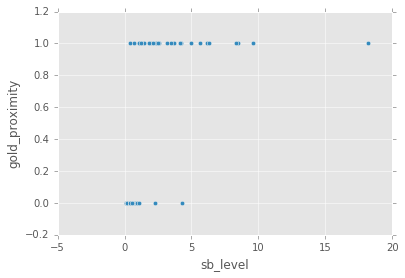

In [12]:
data_df.plot(kind='scatter', x='sb_level', y = 'gold_proximity')

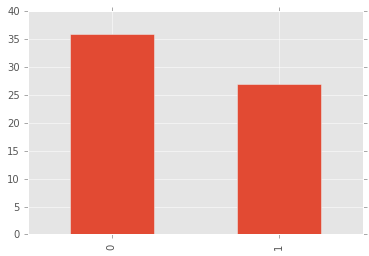

In [17]:
data_df['gold_proximity'].value_counts().plot(kind='bar')

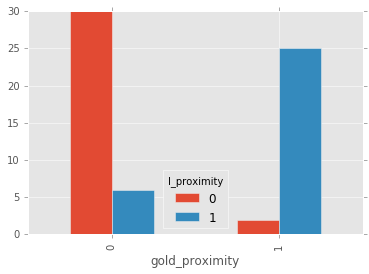

In [21]:
counts = data_df.groupby(['gold_proximity', 'l_proximity']).size()
counts.unstack().plot(kind='bar')

In [24]:
import statsmodels.formula.api as sm
model = sm.logit(formula='gold_proximity ~ C(l_proximity)', data=data_df)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.360516
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         gold_proximity   No. Observations:                   63
Model:                          Logit   Df Residuals:                       61
Method:                           MLE   Df Model:                            1
Date:                Mon, 17 Apr 2017   Pseudo R-squ.:                  0.4721
Time:                        20:00:51   Log-Likelihood:                -22.712
converged:                       True   LL-Null:                       -43.023
                                        LLR p-value:                 1.848e-10
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.7081      0.730     -3.708      0.000      -4.139      -1.277
C(l_proximity)[T.1]     4.1352      0.860      4.807      0.000       2.449       5.821
=======================================================================================
"""

In [45]:
from sklearn.model_selection import KFold
fold = KFold(n_splits=5, shuffle=True)

def cross_validate(train_index, test_index):
    train_data, test_data = data_df.iloc[train_index], data_df.iloc[test_index]
    
    t_model = sm.logit(formula='gold_proximity ~ C(l_proximity)', data=train_data)
    t_result = t_model.fit()
    t_predict = t_result.predict(test_data)
    t_predict = t_predict.apply(lambda v: 1.0 if v >= 0.5 else 0.0)
    
    return pd.concat({'predicted': t_predict, 'actual': test_data['gold_proximity']}, axis=1)

cv_results = [cross_validate(train_index, test_index) for train_index, test_index in fold.split(data_df.index)]

Optimization terminated successfully.
         Current function value: 0.414925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.277641
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337705
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335184
         Iterations 7


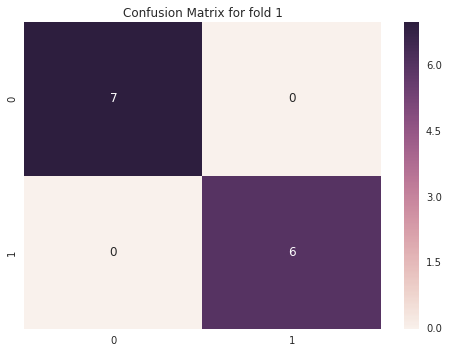

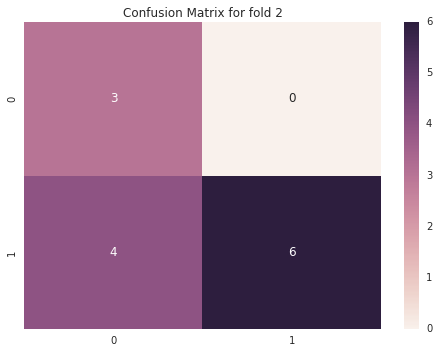

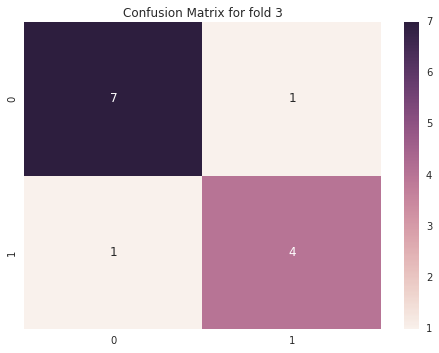

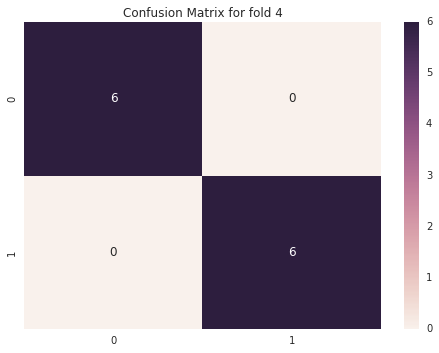

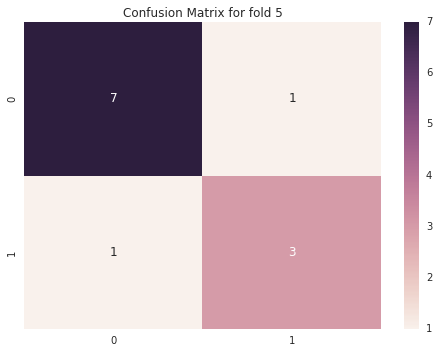

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

for idx, result in enumerate(cv_results):
    c = confusion_matrix(result['predicted'], result['actual'])
    pylab.figure()
    ax = sns.heatmap(c, annot=True)
    ax.set_title('Confusion Matrix for fold %s' % (idx+1))

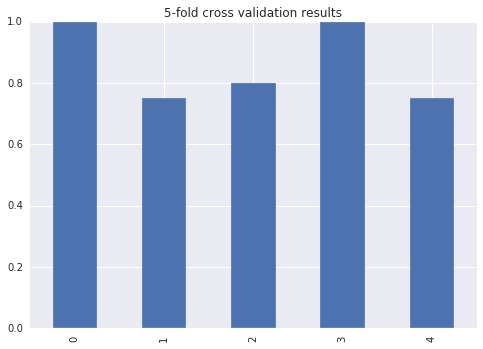

In [48]:
from sklearn.metrics import f1_score

scores = [f1_score(r['predicted'], r['actual']) for r in cv_results]
sc = pd.Series(data=scores, name='F1_scores')
sc.plot(kind='bar', title='5-fold cross validation results')